In [2]:
!pip install category_encoders

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import plotly.express as px
import category_encoders as ce

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest, chi2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.6 MB/s eta 0:00:00


In [3]:
data = pd.read_excel("/content/GermanCreditData.xlsx", sheet_name = 'Sheet1')

# Display the first few rows to understand the structure of dataframe
data.head()

,Checking,Duration,History,Purpose,Amount,Savings,Emploed,Installp,marital,Coapp,...,Age,Other,housing,Existcr,Job,Depends,Telephone,Foreign,Bad,Good
0,1,6,4,3,1169,5,5,4,3,1,...,67,3,2,2,3,1,2,1,0,1
1,2,48,2,3,5951,1,3,2,2,1,...,22,3,2,1,3,1,1,1,1,0
2,4,12,4,6,2096,1,4,2,3,1,...,49,3,2,1,2,2,1,1,0,1
3,1,42,2,2,7882,1,4,2,3,3,...,45,3,3,1,3,2,1,1,0,1
4,1,24,3,0,4870,1,3,3,3,1,...,53,3,3,2,3,2,1,1,1,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Checking   1000 non-null   int64 
 1   Duration   1000 non-null   int64 
 2   History    1000 non-null   int64 
 3   Purpose    1000 non-null   object
 4   Amount     1000 non-null   int64 
 5   Savings    1000 non-null   int64 
 6   Emploed    1000 non-null   int64 
 7   Installp   1000 non-null   int64 
 8   marital    1000 non-null   int64 
 9   Coapp      1000 non-null   int64 
 10  Resident   1000 non-null   int64 
 11  Property   1000 non-null   int64 
 12  Age        1000 non-null   int64 
 13  Other      1000 non-null   int64 
 14  housing    1000 non-null   int64 
 15  Existcr    1000 non-null   int64 
 16  Job        1000 non-null   int64 
 17  Depends    1000 non-null   int64 
 18  Telephone  1000 non-null   int64 
 19  Foreign    1000 non-null   int64 
 20  Bad        1000 non-null   int6

Above, we observe that every column has 1000 entries of data, which means there are no missing values. But to be on the safe side, we calculate the sum of cells where there are no values. If we get any value other than 0, then there is missing value.

In [5]:
# Assuming 'data' is your initial DataFrame
subset1 = data[(data['Checking'] == 1) | (data['Checking'] == 2)]
subset2 = data[(data['Checking'] == 3) | (data['Checking'] == 4)]

In [6]:
# Preparing features and target for both subsets
X1 = subset1.drop(['Good','Bad'], axis=1)  # Assuming 'Checking' is not part of the features
y1 = subset1['Good']

X2 = subset2.drop(['Good','Bad'], axis=1)
y2 = subset2['Good']

# Splitting data
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, test_size=0.2, stratify=y1, random_state=1)

X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size=0.2, stratify=y2, random_state=1)


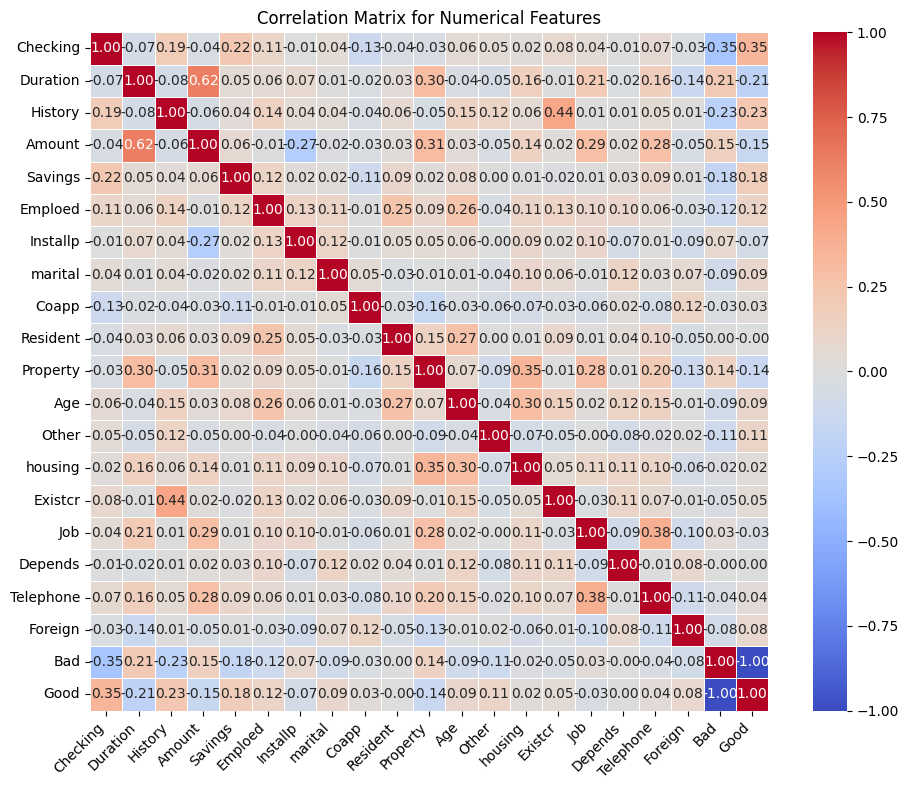

In [7]:
# Assuming 'data' is your DataFrame
w = data.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = w.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))  # You can adjust the size as needed

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": 1})

plt.title('Correlation Matrix for Numerical Features')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.yticks(rotation=0)  # Keep y labels horizontal for consistency
plt.tight_layout()  # Adjust subplots to give some padding between plots and the edges of the figure
plt.show()

In [8]:
# Assuming 'X1' contains both numerical and encoded categorical data
X_train_encoded1 = pd.get_dummies(X1, drop_first=True)

     Feature  Chi2 Score   P-value
5  Purpose_6    4.731574  0.029614
0  Purpose_1    2.875566  0.089933
2  Purpose_3    2.019918  0.155248
6  Purpose_8    1.187153  0.275904
3  Purpose_4    0.475530  0.490454
7  Purpose_9    0.393168  0.530639
1  Purpose_2    0.041102  0.839340
4  Purpose_5    0.010219  0.919479
8  Purpose_X    0.007032  0.933170


<Figure size 1000x600 with 0 Axes>

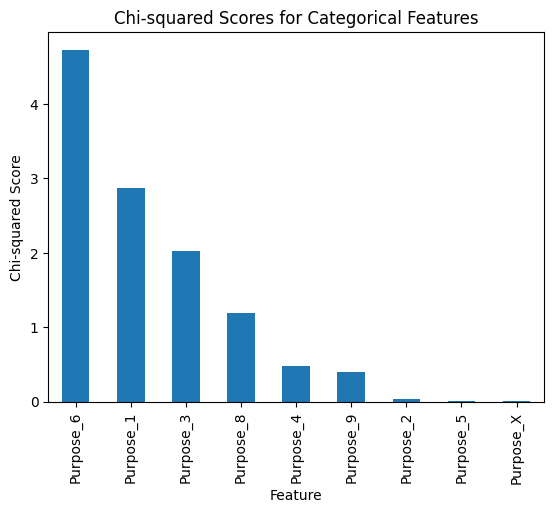

In [9]:
# Selecting the categorical features from the encoded DataFrame
categorical_cols = X_train_encoded1.columns[X_train_encoded1.columns.str.contains('_')]  # Adjust regex based on naming convention of dummy variables
categorical_cols
# Apply SelectKBest with the Chi-squared test to categorical features
chi_selector = SelectKBest(chi2, k='all')  # Use k='all' to score all features, adjust k as necessary
chi_selector.fit(X_train_encoded1[categorical_cols], y1)  # Assuming 'y1' is your target variable

# Get scores and p-values
chi_scores = pd.DataFrame({'Feature': categorical_cols, 'Chi2 Score': chi_selector.scores_, 'P-value': chi_selector.pvalues_})
print(chi_scores.sort_values(by='Chi2 Score', ascending=False))

# Plotting the Chi-squared scores
plt.figure(figsize=(10, 6))
chi_scores.sort_values(by='Chi2 Score', ascending=False).plot(x='Feature', y='Chi2 Score', kind='bar', legend=False)
plt.title('Chi-squared Scores for Categorical Features')
plt.ylabel('Chi-squared Score')
plt.show()

      Feature    F Score       P-value
1    Duration  35.620318  4.339790e-09
2     History  27.566028  2.185160e-07
10   Property  24.751230  8.776336e-07
4     Savings  15.774755  8.099962e-05
3      Amount  11.575790  7.175908e-04
8       Coapp   7.169476  7.640695e-03
6    Installp   5.856275  1.585009e-02
0    Checking   5.807595  1.628986e-02
7     marital   5.029163  2.532813e-02
18    Foreign   4.957054  2.639544e-02
15        Job   2.283735  1.313205e-01
11        Age   1.767998  1.841905e-01
14    Existcr   1.242529  2.654791e-01
12      Other   0.837096  3.606364e-01
5     Emploed   0.653145  4.193457e-01
16    Depends   0.414529  5.199524e-01
9    Resident   0.388327  5.334428e-01
17  Telephone   0.117736  7.316366e-01
13    housing   0.101521  7.501345e-01


<Figure size 1000x600 with 0 Axes>

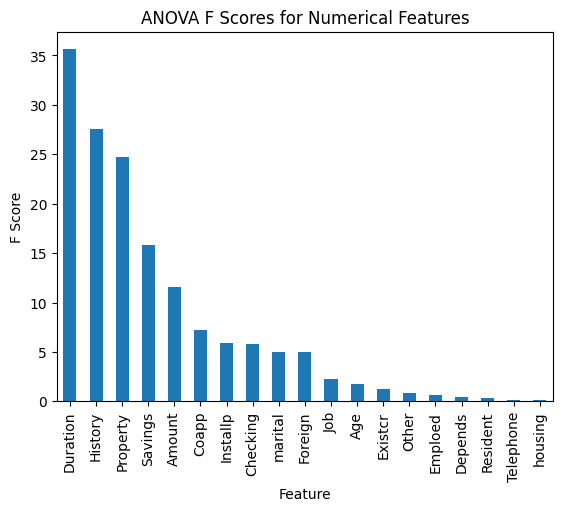

In [10]:
# Selecting numerical features
numerical_cols = X_train_encoded1.columns[~X_train_encoded1.columns.str.contains('_')]  # Adjust condition based on your DataFrame

# Apply SelectKBest with ANOVA F-statistic to numerical features
f_selector = SelectKBest(f_classif, k='all')  # Use k='all' to score all features
f_selector.fit(X_train_encoded1[numerical_cols], y1)

# Get scores and p-values
f_scores = pd.DataFrame({'Feature': numerical_cols, 'F Score': f_selector.scores_, 'P-value': f_selector.pvalues_})
print(f_scores.sort_values(by='F Score', ascending=False))

# Plotting the ANOVA F scores
plt.figure(figsize=(10, 6))
f_scores.sort_values(by='F Score', ascending=False).plot(x='Feature', y='F Score', kind='bar', legend=False)
plt.title('ANOVA F Scores for Numerical Features')
plt.ylabel('F Score')
plt.show()


### Analysis of Provided Data

1. **Top Features by F Score**:
   - **Duration**: With the highest F score and a very low p-value, this feature is highly significant in predicting the outcome. It has the greatest impact among all the features.
   - **History** and **Property**: Both features also show high F scores and very low p-values, marking them as significant predictors in the model.

2. **Features with Moderate F Scores**:
   - **Savings, Amount, Coapp, Installp, Checking, Marital, Foreign**: These features have moderate F scores and their p-values are less than 0.05, suggesting they are statistically significant but less impactful compared to the top features.

3. **Low Impact Features**:
   - **Job, Age, Existcr, and others lower down the list**: These features have lower F scores and higher p-values, some exceeding the typical significance threshold of 0.05, indicating weaker evidence against the null hypothesis. This suggests they have a limited impact on the model's predictive ability.



---



### Interpretation of ANOVA F Scores and P-values

- **F Score**: Indicates the ratio of the variance between groups (defined by the feature in question) to the variance within groups. A higher F score suggests that the feature has a stronger discriminatory power with respect to the outcome variable.
- **P-value**: Helps in determining the significance of the results. A low p-value (typically < 0.05) indicates that you can reject the null hypothesis that the feature has no effect on the outcome.

In [11]:
# Binarize 'Amount'
X_train1['Amount_binned'] = pd.cut(X_train1['Amount'], bins=5, labels=False, duplicates='drop')
X_val1['Amount_binned'] = pd.cut(X_val1['Amount'], bins=5, labels=False, duplicates='drop')

# Binarize 'Age'
X_train1['Age_binned'] = pd.cut(X_train1['Age'], bins=5,labels=False, duplicates='drop')
X_val1['Age_binned'] = pd.cut(X_val1['Age'], bins=5,labels=False, duplicates='drop')

# Binarize 'Duration'
X_train2['Duration_binned'] = pd.cut(X_train2['Duration'], bins=5, labels=False, duplicates='drop')
X_val2['Duration_binned'] = pd.cut(X_val2['Duration'], bins=5, labels=False, duplicates='drop')

# Binarize 'Installp' (Installment percentage)
X_train2['Installp_binned'] = pd.cut(X_train2['Installp'], bins=5, labels=False, duplicates='drop')
X_val2['Installp_binned'] = pd.cut(X_val2['Installp'], bins=5, labels=False, duplicates='drop')

In [12]:
# Including binned versions instead of raw data
X_train1 = X_train1[['Amount_binned', 'Age_binned']]
X_val1 = X_val1[['Amount_binned', 'Age_binned']]

X_train2 = X_train2[['Duration_binned', 'Installp_binned']]
X_val2 = X_val2[['Duration_binned', 'Installp_binned']]

scaler = StandardScaler()

# Scale Set 1
X_train1_scaled = scaler.fit_transform(X_train1)
X_train1 = pd.DataFrame(X_train1_scaled, columns=X_train1.columns, index=X_train1.index)

X_val1_scaled = scaler.fit_transform(X_val1)
X_val1 = pd.DataFrame(X_val1_scaled, columns=X_val1.columns, index=X_val1.index)

# Scale Set 2
X_train2_scaled = scaler.fit_transform(X_train2)
X_train2 = pd.DataFrame(X_train2_scaled, columns=X_train2.columns, index=X_train2.index)

X_val2_scaled = scaler.fit_transform(X_val2)
X_val2 = pd.DataFrame(X_val2_scaled, columns=X_val2.columns, index=X_val2.index)

In [13]:
## Re-adding 'Savings' and 'History' to X_train1 from the original 'data' DataFrame
X_train1['Savings'] = data['Savings']
X_train1['History'] = data['History']

X_val1['Savings'] = data['Savings']
X_val1['History'] = data['History']

## Re-adding 'Property' and 'Coapp'-coapplicant to X_train1 from the original 'data' DataFrame
X_train2['Property'] = data['Property']
X_train2['Coapp'] = data['Coapp']

X_val2['Property'] = data['Property']
X_val2['Coapp'] = data['Coapp']

# Now check the data to ensure columns are added
print(X_train2.head())

     Duration_binned  Installp_binned  Property  Coapp
263        -0.843544        -1.016994         4      1
698         0.272012         0.899716         3      1
798         0.272012         0.899716         3      1
228        -0.843544         0.899716         3      1
82          0.272012         0.260813         2      1


In [14]:
def binary_encode(data, columns):
    encoder = ce.BinaryEncoder(cols=columns)
    return encoder.fit_transform(data)

X_train1 = binary_encode(X_train1.copy(), ['Savings', 'History'])
X_val1 = binary_encode(X_val1.copy(), ['Savings', 'History'])
X_train2 = binary_encode(X_train2.copy(), ['Property', 'Coapp'])
X_val2 = binary_encode(X_val2.copy(), ['Property', 'Coapp'])

In [15]:
X_val1.head()

,Amount_binned,Age_binned,Savings_0,Savings_1,Savings_2,History_0,History_1,History_2
605,-0.687730,-0.753085,0,0,1,0,0,1
585,-0.687730,-0.753085,0,1,0,0,1,0
565,-0.687730,-0.753085,0,1,1,0,1,1
558,0.383164,-0.753085,0,1,0,0,0,1
838,-0.687730,1.866690,0,1,0,1,0,0


In [16]:
# Initialize the models
lin_reg1 = LinearRegression(fit_intercept = True)
log_reg1 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', max_iter=100)

lin_reg2 = LinearRegression()
log_reg2 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', max_iter=100)

# Fit the models
lin_reg1.fit(X_train1, y_train1)
log_reg1.fit(X_train1, y_train1)

lin_reg2.fit(X_train2, y_train2)
log_reg2.fit(X_train2, y_train2)

LogisticRegression(penalty='l1', solver='liblinear')

In [17]:
# Linear Regression Predictions
y_pred_lin1 = lin_reg1.predict(X_val1)
y_pred_lin2 = lin_reg2.predict(X_val2)

# Logistic Regression Predictions
y_pred_log1 = log_reg1.predict(X_val1)
y_pred_prob_log1 = log_reg1.predict_proba(X_val1)[:, 1]

y_pred_log2 = log_reg2.predict(X_val2)
y_pred_prob_log2 = log_reg2.predict_proba(X_val2)[:, 1]

In [18]:
# Calculate MSE for both subsets
mse_lin1 = mean_squared_error(y_val1, y_pred_lin1)
mse_lin2 = mean_squared_error(y_val2, y_pred_lin2)

# Calculate R-squared for both subsets
r_squared1 = r2_score(y_val1, y_pred_lin1)
r_squared2 = r2_score(y_val2, y_pred_lin2)

# Print Linear Regression metrics
print("Scorecard 1: Linear Regression")
print(f"Mean Squared Error: {mse_lin1:.4f}")
print(f"R-squared: {r_squared1:.4f}")

print("\nScorecard 3: Linear Regression ")
print(f"Mean Squared Error: {mse_lin2:.4f}")
print(f"R-squared: {r_squared2:.4f}")


Scorecard 1: Linear Regression
Mean Squared Error: 0.2415
R-squared: 0.0202

Scorecard 3: Linear Regression 
Mean Squared Error: 0.1106
R-squared: 0.0248


### Analysis of the Metrics

#### Scorecard 1:
- **MSE: 0.2415**
  - This value indicates that on average, the square of the error between the model’s predictions and the actual values is 0.2415. This can be considered relatively high depending on the variance of your response variable and the scale of measurement.
- **R-squared: 0.0202**
  - An R-squared of approximately 2.02% is very low, suggesting that only about 2% of the variability in the dependent variable can be explained by the model. This implies that the model is not effectively capturing the patterns or trends in the data, which might be due to insufficient or irrelevant predictor variables, or non-linear relationships not captured by the model.

#### Scorecard 3:
- **MSE: 0.1106**
  - A lower MSE here suggests that the predictions of this model are closer to the actual data points than those of Scorecard 1. This indicates a better model fit to the data.
- **R-squared: 0.0248**
  - Similar to Scorecard 1, an R-squared of 2.48% also indicates a poor fit. Although slightly better than Scorecard 1, this model still explains a very small fraction of the variance in the dependent variable.

In [19]:
# Accuracy for logistic models
accuracy_log1 = accuracy_score(y_val1, y_pred_log1)
accuracy_log2 = accuracy_score(y_val2, y_pred_log2)

# Confusion Matrix and Classification Report
cm_log1 = confusion_matrix(y_val1, y_pred_log1)
report_log1 = classification_report(y_val1, y_pred_log1, zero_division=0)

cm_log2 = confusion_matrix(y_val2, y_pred_log2)
report_log2 = classification_report(y_val2, y_pred_log2, zero_division=0)

# ROC AUC
roc_auc_log1 = roc_auc_score(y_val1, y_pred_prob_log1)
roc_auc_log2 = roc_auc_score(y_val2, y_pred_prob_log2)

# Print Logistic Regression metrics
print("Logistic Regression - Scorecard 2:")
print(f"Accuracy: {accuracy_log1:.4f}")

print("Classification Report:")
print(report_log1)
print(f"ROC AUC Score: {roc_auc_log1:.4f}\n")

print("Logistic Regression - Scorecard 4:")
print(f"Accuracy: {accuracy_log2:.4f}")

print("Classification Report:")
print(report_log2)
print(f"ROC AUC Score: {roc_auc_log2:.4f}\n")


Logistic Regression - Scorecard 2:
Accuracy: 0.5229
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.58      0.52        48
           1       0.59      0.48      0.53        61

    accuracy                           0.52       109
   macro avg       0.53      0.53      0.52       109
weighted avg       0.54      0.52      0.52       109

ROC AUC Score: 0.6031

Logistic Regression - Scorecard 4:
Accuracy: 0.8696
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.87      1.00      0.93        80

    accuracy                           0.87        92
   macro avg       0.43      0.50      0.47        92
weighted avg       0.76      0.87      0.81        92

ROC AUC Score: 0.7437



### Scorecard 2 Analysis
- **Accuracy**: 52.29% indicates a performance close to a coin flip, suggesting that the model is not very effective.
- **Precision and Recall**:
  - **Class 0 (Precision: 0.47, Recall: 0.58)**: The model is able to identify 58% of all actual negatives but is correct only 47% of the time when it predicts a negative class.
  - **Class 1 (Precision: 0.59, Recall: 0.48)**: The model identifies 48% of all actual positives, and when it predicts a positive, it is correct 59% of the time.
- **F1-Score**: Similar F1-scores for both classes around 0.52-0.53, indicating a balance between precision and recall but at a low performance level.
- **ROC AUC Score**: 0.6031 suggests the model has limited discrimination ability — better than random but far from ideal.

### Scorecard 4 Analysis
- **Accuracy**: 86.96% suggests high overall accuracy, but this metric may be misleading due to class imbalance.
- **Precision and Recall**:
  - **Class 0 (Precision: 0.00, Recall: 0.00)**: The model fails to correctly identify any of the negative cases, which is a significant issue.
  - **Class 1 (Precision: 0.87, Recall: 1.00)**: The model perfectly identifies all positive cases but with high precision, indicating possible overfitting to the majority class.
- **F1-Score**: The F1-score for Class 0 is 0.00 due to no correct negative predictions, while it's quite high for Class 1 due to the model predicting nearly all instances as Class 1.
- **ROC AUC Score**: 0.7437 reflects a decent ability to distinguish between the classes, but the lack of negative predictions points to issues with model calibration or class imbalance.

In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Applying sigmoid to linear regression outputs to convert them to probabilities
y_pred_prob_lin1 = sigmoid(y_pred_lin1)
y_pred_prob_lin2 = sigmoid(y_pred_lin2)

In [21]:
# Calculate the ROC AUC scores
roc_auc1_lin = roc_auc_score(y_val1, y_pred_prob_lin1)
roc_auc2_lin = roc_auc_score(y_val2, y_pred_prob_lin2)

# Derive ROC curve for scorecard 1
fpr1_lin, tpr1_lin, thresholds1 = roc_curve(y_val1, y_pred_prob_lin1)

# Generate ROC curve values for Scorecard 2
fpr1_log, tpr1_log, thresholds1 = roc_curve(y_val1, y_pred_prob_log1, pos_label=0)

#Derive ROC curve for scorecard 3
fpr2_lin, tpr2_lin, thresholds2 = roc_curve(y_val2, y_pred_prob_lin2)

# Generate ROC curve values for Scorecard 4
fpr2_log, tpr2_log, thresholds2 = roc_curve(y_val2, y_pred_prob_log2, pos_label=0)

### Linear Regression ROC plots

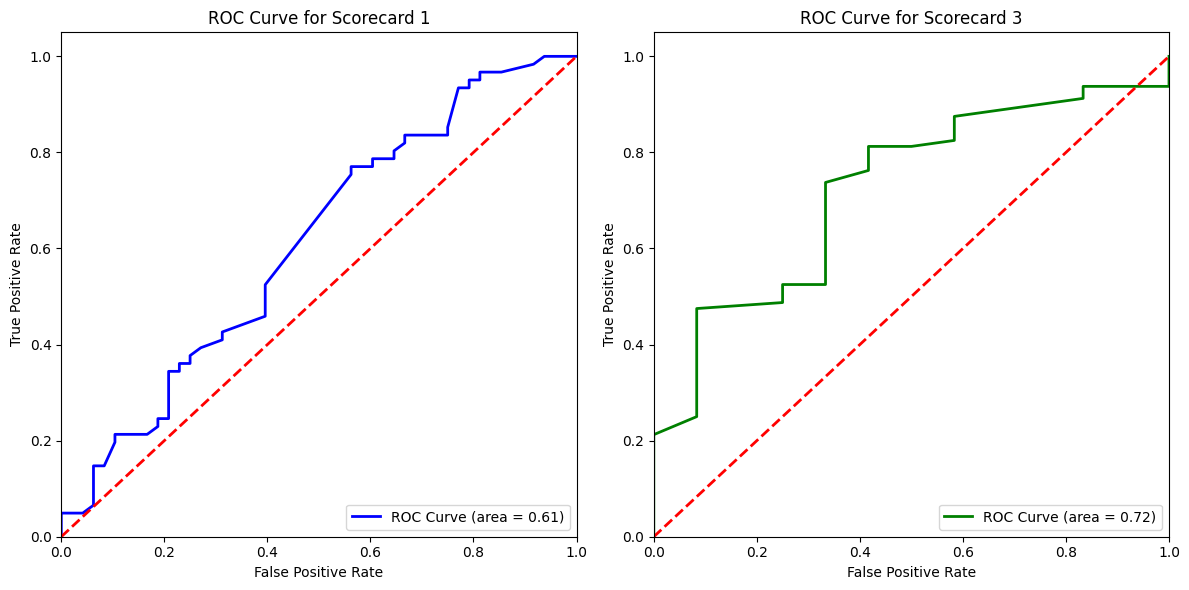

In [22]:
plt.figure(figsize=(12, 6))

# Plot ROC curve for Scorecard 1
plt.subplot(1, 2, 1)
plt.plot(fpr1_lin, tpr1_lin, color='blue', lw=2, label='ROC Curve (area = %0.2f)' % roc_auc1_lin)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Scorecard 1')
plt.legend(loc="lower right")

# Plot ROC curve for Scorecard 3
plt.subplot(1, 2, 2)
plt.plot(fpr2_lin, tpr2_lin, color='green', lw=2, label='ROC Curve (area = %0.2f)' % roc_auc2_lin)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Scorecard 3')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

### ROC Curve Analysis

1. **Scorecard 1: AUC = 0.61**
   - **Interpretation**: The AUC score of 0.61 for Scorecard 1 suggests that the model has moderate discriminatory power. It is somewhat effective at distinguishing between positive and negative outcomes, but not significantly so. The ROC curve shows that the model performs better than random chance (AUC = 0.50), but it does not ascend rapidly towards the top-left corner of the plot, indicating that there is considerable room for improvement in both sensitivity and specificity.

2. **Scorecard 3: AUC = 0.72**
   - **Interpretation**: An AUC of 0.72 indicates a good level of discrimination ability. This scorecard's model is substantially better at distinguishing between the outcomes compared to Scorecard 1. The curve, which moves closer to the upper left corner, suggests that the model correctly identifies a higher proportion of true positives at lower rates of false positives, which is indicative of a more robust predictive model.


### Logistic regression ROC plots


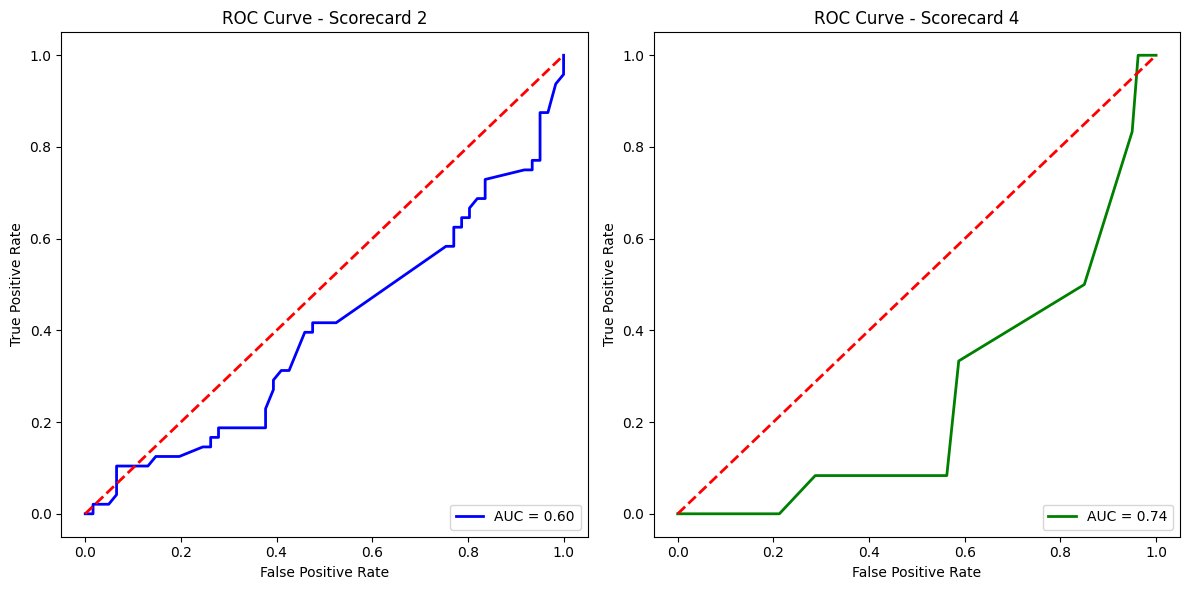

In [23]:
plt.figure(figsize=(12, 6))

# Plot ROC curve for Scorecard 2
plt.subplot(1, 2, 1)
plt.plot(fpr1_log, tpr1_log, color='blue', lw=2, label=f'AUC = {roc_auc_score(y_val1, y_pred_prob_log1):.2f}')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle = '--')
plt.title('ROC Curve - Scorecard 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Plot ROC curve for Scorecard 4
plt.subplot(1, 2, 2)
plt.plot(fpr2_log, tpr2_log, color='green', lw=2, label=f'AUC = {roc_auc_score(y_val2, y_pred_prob_log2):.2f}')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle = '--')
plt.title('ROC Curve - Scorecard 4')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### ROC Curve Analysis

1. **Scorecard 2: AUC = 0.60**
   - **Interpretation**: The AUC of 0.60 indicates that Scorecard 2 has limited ability to distinguish between the classes. An AUC score of 0.60 means the model is somewhat better than random guessing (AUC = 0.50) but still shows considerable room for improvement. The ROC curve shows some progression above the diagonal line (which represents random chance), but the incremental gain over this line is not very significant throughout most of the curve range.

2. **Scorecard 4: AUC = 0.74**
   - **Interpretation**: The AUC of 0.74 for Scorecard 4 suggests a good discrimination ability. This model is substantially better at distinguishing between the positive and negative classes than Scorecard 2. The curve climbs quickly towards the upper left corner, indicating a high true positive rate (sensitivity) for a relatively low false positive rate (specificity), which is desirable in a predictive model.

### Gini coefficient

In [24]:
# Gini Coefficients
gini1_lin = 2 * roc_auc1_lin - 1
print('Gini coefficient for scorecard 1:',gini1_lin)

gini1_log = 2 * (roc_auc_score(y_val1, y_pred_prob_log1)) - 1
print('\nGini coefficient for scorecard 2:', gini1_log)

gini2_lin = 2 * roc_auc2_lin - 1
print('\nGini coefficient for scorecard 3:',gini2_lin)

gini2_log = 2 * (roc_auc_score(y_val2, y_pred_prob_log2)) - 1
print('\nGini coefficient for scorecard 4:', gini2_log)

Gini coefficient for scorecard 1: 0.21926229508196737

Gini coefficient for scorecard 2: 0.20628415300546443

Gini coefficient for scorecard 3: 0.44270833333333326

Gini coefficient for scorecard 4: 0.4874999999999998


### Interpretation of Gini Coefficients

1. **Scorecard 1: 0.2193**
   - **Interpretation**: This Gini coefficient indicates a good ability to discriminate between the positive and negative outcomes. It shows that the model performs significantly better than random guessing (which would be indicated by a Gini coefficient of 0). A Gini coefficient around 0.22 suggests that the model is useful for making informed predictions, though there's still room for improvement.

2. **Scorecard 2: 0.2063**
   - **Interpretation**: Similar to Scorecard 1, this model has a good but slightly lower discriminatory power compared to Scorecard 1. It's also above the threshold of random guessing, confirming its utility in predictive scenarios. The model is effective but could benefit from further refinement to enhance its accuracy.

3. **Scorecard 3: 0.4427**
   - **Interpretation**: A Gini coefficient of nearly 0.44 indicates excellent discrimination. This model is highly effective at differentiating between the classes and is capable of making very reliable predictions. It ranks among the higher-performing models in typical credit scoring contexts.

4. **Scorecard 4: 0.4875**
   - **Interpretation**: This is an exceptionally high Gini coefficient, nearly reaching 0.5, which suggests outstanding discrimination ability. This model excels at identifying differences between positive and negative groups and would be extremely valuable in environments where precise risk assessment is critical.

### Kolmogorov-Smirnov (KS) Statistic

In [25]:
# KS Statistics
ks1_lin = max(tpr1_lin - fpr1_lin)
print('KS statistic for scorecard 1:', ks1_lin)

ks1_log = max(tpr1_log - fpr1_log)
print('\nKS statistic for scorecard 2:', ks1_log)

ks2_lin = max(tpr2_lin - fpr2_lin)
print('\nKS statistic for scorecard 3:', ks2_lin)

ks2_log = max(tpr2_log - fpr2_log)
print('\nKS statistic for scorecard 4:', ks2_log)

KS statistic for scorecard 1: 0.2079918032786885

KS statistic for scorecard 2: 0.03859289617486339

KS statistic for scorecard 3: 0.40416666666666673

KS statistic for scorecard 4: 0.03749999999999998


### Interpretation of KS Statistics

1. **Scorecard 1: 0.2080**
   - **Interpretation**: A KS statistic of 20.80% indicates good discrimination ability. This value suggests that the model can effectively differentiate between the classes, identifying potential defaults with reasonable accuracy. A value above 20% is typically considered good in many financial applications.

2. **Scorecard 2: 0.0386**
   - **Interpretation**: A very low KS statistic of 3.86% suggests poor discriminatory power. This model struggles significantly to differentiate between the positive and negative classes, almost approaching random guessing. This is indicative of a model that may not be useful for practical decision-making without substantial improvement.

3. **Scorecard 3: 0.4042**
   - **Interpretation**: An exceptionally high KS statistic of 40.42% shows excellent discrimination capability. This scorecard is highly effective at distinguishing between the two classes, making it potentially very reliable for predicting outcomes. Such a high value is indicative of a strong model, although it's also prudent to ensure it's not overfitting.

4. **Scorecard 4: 0.0375**
   - **Interpretation**: Similar to Scorecard 2, a KS statistic of 3.75% is extremely low, indicating that the model performs only slightly better than random guessing at separating the classes. This model likely requires a complete overhaul or reconsideration of the approach used.




---

